# Исследование потенциально проигрышных маркетинговых решений для приложения Procrastinate Pro+

В моем распоряжении данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях (visits_info_short.cs)
- выгрузка их покупок за этот период (orders_info_short.csv)
- рекламные расходы (costs_info_short.csv)

О качестве исходных данных ничего не известно, поэтому первым делом выполним изучение и предобработку для подготовки данных к анализу

<b>Цель исследования: </b>
изучить:
- откуда приходят пользователи и какими устройствами они пользуются
- сколько стоит привлечение пользователей из различных рекламных каналов
- сколько денег приносит каждый клиент
- когда расходы на привлечение клиента окупаются
- какие факторы мешают привлечению клиентов 
- разобраться в причинах убытков и помочь компании выйти в плюс

<b>Ход исследования:</b>
- изучить датасеты, выполнить предобработку и подготовку данных 
- задайть функции для расчёта и анализа LTV, ROI, удержания и конверсии
- составить профили пользователей с разбивками по устройствам, регионам, и каналам привлечения
- изучить и визуализировать расходы на маркетинг
- используя графики LTV, ROI и CAC, оценить окупаемость рекламы
- выделить причины неэффективности привлечения пользователей и сформулировать рекомендации для маркетингового отдела

### Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs = pd.read_csv('/datasets/costs_info_short.csv')

#### Обработка visits

In [3]:
#смотрим visits
visits.info()
visits.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


User Id         Region   Device         Channel        Session Start  \
0  981449118918  United States   iPhone         organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone         organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac         organic  2019-05-01 14:09:25   
3  326433527971  United States  Android          TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac         organic  2019-05-01 03:33:35   
5   90242400005  United States   iPhone  RocketSuperAds  2019-05-01 07:14:52   
6   43958116050  United States  Android         organic  2019-05-01 09:03:21   
7  185365244969  United States   iPhone         organic  2019-05-01 09:37:03   
8  446013509831  United States   iPhone  RocketSuperAds  2019-05-01 10:26:00   
9  100970711362  United States      Mac          TipTop  2019-05-01 04:39:53   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40  
5  2019-05-01 08:19:56  
6  2019-05-01 10:08:39  
7  2019-05-01 10:00:43  
8  2019-05-01 10:59:17  
9  2019-05-01 04:57:05

309901 сеансов. 6 столбцов с данными без пропущенных значений. Приведем названия столбцов к нижнему регистру, приведем столбцы с датами к нужному формату и проверим дубликаты

In [4]:
#переименуем колонки
visits = visits.rename(columns={'User Id':'user_id', 'Region' : 'region', 
                                'Device':'device', 'Channel':'channel', 'Session Start' : 'session_start', 
                                'Session End': 'session_end'})

In [5]:
#приведем session start + session end to datetime
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])


In [6]:
#проверим на дубликаты и пропуски
print(visits.duplicated().sum())
print(visits.isnull().sum())

0
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64


дубликатов нет. привели названия колонок к нижнему регистру для дальнейшей простоты использования функций. Временные колонки отформатировали к формату дат. смотрим дальше

#### Обработка orders

In [7]:
orders.info()
orders.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99
5  129100331057  2019-05-01 01:56:28     4.99
6  626807144131  2019-05-01 02:39:21     4.99
7  914062168985  2019-05-01 02:02:18     4.99
8  769669137453  2019-05-01 03:39:47     4.99
9  434198630691  2019-05-01 18:16:50     5.99

In [8]:
#переименуем колонки
orders = orders.rename(columns={'User Id':'user_id', 'Event Dt' : 'event_dt', 'Revenue':'revenue'})

In [9]:
#приведем event dt to datetime
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [10]:
#проверим пропуски и дубликаты
print(orders.duplicated().sum())
orders.isnull().sum()

0


user_id     0
event_dt    0
revenue     0
dtype: int64

дубликатов нет. привели названия колонок к нижнему регистру для дальнейшей простоты использования функций. Временную колонку отформатировали к формату дат. смотрим дальше

#### Обработка costs

In [11]:
#смотрим последний дф 
costs.info()
costs.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1
5  2019-05-06  FaceBoom  118.8
6  2019-05-07  FaceBoom  101.2
7  2019-05-08  FaceBoom  100.1
8  2019-05-09  FaceBoom   93.5
9  2019-05-10  FaceBoom  104.5

In [12]:
#переименуем
costs = costs.rename(columns={'Channel' : 'channel'})

In [13]:
#приведем dt to datetime
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [14]:
#проверим пропуски и дубликаты
print(costs.duplicated().sum())
costs.isnull().sum()

0


dt         0
channel    0
costs      0
dtype: int64

дубликатов нет. привели названия колонки channel к нижнему регистру для дальнейшей простоты использования функций. Временные колонки отформатировали к формату дат. Можно приступать к анализу

### Функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

#### get profiles

In [15]:
def get_profiles(sessions, orders, costs, event_names=[]):
    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    # для когортного анализа определяем дату первого посещения и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователейс одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_costs'] = costs['costs'] / costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_costs']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_costs'] = profiles['acquisition_costs'].fillna(0)
    return profiles

#### get retention

In [16]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### get conversion

In [17]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):


    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')


    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )


    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result


    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)


    if 'cohort' in dimensions: 
        dimensions = []


    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )


    return result_raw, result_grouped, result_in_time

#### get ltv

In [18]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):


    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):
        
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes


        cac = df[['user_id', 'acquisition_costs'] + dims].drop_duplicates()


        cac = (
            cac.groupby(dims)
            .agg({'acquisition_costs': 'mean'})
            .rename(columns={'acquisition_costs': 'cac'})
        )


        roi = result.div(cac['cac'], axis=0)


        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']


        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]


        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### filter data

In [19]:
# функция для сглаживания фрейма

def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

#### plot retention

In [20]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))
    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')


    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]

    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### plot conversion

In [21]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])

    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')


    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### plot ltv roi

In [22]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]


    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составление профилей пользователей. Определение минимальной и максимальной дат привлечения пользователей.
- Определение, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей.
- Определение устройств, которыми пользуются клиенты, и какие устройства предпочитают платящие пользователи.
- Изучение рекламных источников привлечения и определение каналов, из которых пришло больше всего платящих пользователей. 

#### Составление пользовательского профиля

In [23]:
profiles = get_profiles(visits, orders, costs)
display(profiles.info())
profiles.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150008 entries, 0 to 150007
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   user_id            150008 non-null  int64         
 1   first_ts           150008 non-null  datetime64[ns]
 2   channel            150008 non-null  object        
 3   device             150008 non-null  object        
 4   region             150008 non-null  object        
 5   dt                 150008 non-null  object        
 6   month              150008 non-null  datetime64[ns]
 7   payer              150008 non-null  bool          
 8   acquisition_costs  150008 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 10.4+ MB


None

user_id            first_ts       channel   device         region  \
0    599326 2019-05-07 20:58:57      FaceBoom      Mac  United States   
1   4919697 2019-07-09 12:46:07      FaceBoom   iPhone  United States   
2   6085896 2019-10-01 09:58:33       organic   iPhone         France   
3  22593348 2019-08-22 21:35:48    AdNonSense       PC        Germany   
4  31989216 2019-10-02 00:07:44       YRabbit   iPhone  United States   
5  34186288 2019-05-09 17:29:23       organic  Android  United States   
6  38448301 2019-08-16 11:56:00       organic  Android  United States   
7  46006712 2019-06-30 03:46:29    AdNonSense  Android         France   
8  58263264 2019-05-11 19:18:43      FaceBoom   iPhone  United States   
9  59835779 2019-05-11 21:13:47  MediaTornado   iPhone  United States   

           dt      month  payer  acquisition_costs  
0  2019-05-07 2019-05-01   True           1.088172  
1  2019-07-09 2019-07-01  False           1.107237  
2  2019-10-01 2019-10-01  False           0.000000  
3  2019-08-22 2019-08-01  False           0.988235  
4  2019-10-02 2019-10-01  False           0.230769  
5  2019-05-09 2019-05-01  False           0.000000  
6  2019-08-16 2019-08-01  False           0.000000  
7  2019-06-30 2019-06-01   True           1.008000  
8  2019-05-11 2019-05-01  False           1.128205  
9  2019-05-11 2019-05-01  False           0.250435

In [24]:
max_date = profiles['dt'].max()
min_date = profiles['dt'].min()
print('MAX: ', max_date, '\nMIN: ', min_date)

MAX:  2019-10-27 
MIN:  2019-05-01


Таблица профилей с временем привлечений и затрат на рекламу создана. Всего 150008 пользователей в системе. Максимальная дата привлечения юзера = 27.10.2019. Минимальная = 01.05.2019. Сроки совпадают с исходной информацией о датах

#### Распределение платящих пользователей по странам

In [25]:
profiles_region = profiles.pivot_table(index='region', values='payer', aggfunc={'count', 'sum'})
profiles_region['%_of_payers'] = (profiles_region['sum'] / profiles_region['count'] * 100).round(2) 
profiles_region.sort_values(by='%_of_payers', ascending=False)

count   sum  %_of_payers
region                                  
United States  100002  6902         6.90
Germany         14981   616         4.11
UK              17575   700         3.98
France          17450   663         3.80

Платящие пользователи из 4х стран: США (6.9% платящих юзеров), Германия (4.1%), Великобритания (3.98%), Франция (3.8%). Что сразу бросается в глаза - на первый взгляд, США лидирует в списке. НО! % плятящих пользователей слишком мал, учитывая, что пользователей из США = 67% от всего кол-ва пользователей. Это первый тревожный звоночек. И выглядит он как самая главная проблема. Исследование можно закрывать :D Возможно, маркетологам нужно брать рекламу нацеленную на европейскую аудиторию, что мы и проверим в дальнейшем анализе

#### Распределение пользователей по устройствам

In [26]:
profiles_device = profiles.pivot_table(index='device', values='payer', aggfunc={'count', 'sum'})
profiles_device['%_of_payers'] = (profiles_device['sum'] / profiles_device['count'] * 100).round(2) 
profiles_device.sort_values(by='%_of_payers', ascending=False)

count   sum  %_of_payers
device                           
Mac      30042  1912         6.36
iPhone   54479  3382         6.21
Android  35032  2050         5.85
PC       30455  1537         5.05

Наибольшее кол-во платящих юзеров используют технику apple (Mac пользователи = 6.36%, iphone = 6.21). Андроид и ПК юзеры отстают, но разница назначительная (5.85% и 5.05% соответственно). 

#### Распределение пользователей по рекламным каналам

In [27]:
profiles_channels = profiles.pivot_table(index='channel', values='payer', aggfunc={'count', 'sum'})
profiles_channels['%_of_payers'] = (profiles_channels['sum'] / profiles_channels['count'] * 100).round(2)
profiles_channels.sort_values(by='%_of_payers', ascending=False)

count   sum  %_of_payers
channel                                     
FaceBoom            29144  3557        12.20
AdNonSense           3880   440        11.34
lambdaMediaAds       2149   225        10.47
TipTop              19561  1878         9.60
RocketSuperAds       4448   352         7.91
WahooNetBanner       8553   453         5.30
YRabbit              4312   165         3.83
MediaTornado         4364   156         3.57
LeapBob              8553   262         3.06
OppleCreativeMedia   8605   233         2.71
organic             56439  1160         2.06

Слишком сильно бросается в глаза факт, что показатели самых'многочисленных' каналов (FaceBoom + TipTop), хоть они и находятся в топе по % плательщиков, ненамного превышают показатели менее больших групп . Возможно, реклама в этих двух каналах самая дешевая, поэтому туда весь бюджет сливали для привлечения максимально возможного кол-ва юзеров. каналы AdNonSense и lambdaMediaAds выглядят САМЫМИ потенциально прибыльным (11% всего лишь с 3880 привлеченных пользователей и 10.47% из общего 2149 кол-ва). Также нужно перестать покупать рекламу из каналов OppleCreativeMedia, LeapBob и MediaTornado. Судя по всему - они не окупаются совсем. Проверим теории на графиках в следующих шагах

### Маркетинг

- Расчет общей суммы расходов на маркетинг.
- Определение, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- График с визуализацией динамики изменения расходов во времени по неделям по каждому источнику. 
- График с динамикой изменения расходов во времени по месяцам по каждому источнику.
- Определение, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.


#### Расходы на маркетинг по каналам

In [28]:
#Посмотрим, сколько всего бюджета было потрачено на рекламы по всем источникам
print('Общие расходы на маркетинг: ', costs['costs'].sum().round(2))

Общие расходы на маркетинг:  105497.3


In [29]:
#Посмотрим на рекламные расходы по каждому каналу по отдельности
channels_spendings = costs.groupby('channel').agg('sum').sort_values(by=('costs'), ascending=False)
channels_spendings['% от всех расходов'] = round(channels_spendings.costs / channels_spendings.costs.sum() * 100, 2)
channels_spendings = channels_spendings.rename(columns={'channel': 'канал', 'costs': 'расходы'})
channels_spendings

расходы  % от всех расходов
channel                                         
TipTop              54751.30               51.90
FaceBoom            32445.60               30.75
WahooNetBanner       5151.00                4.88
AdNonSense           3911.25                3.71
OppleCreativeMedia   2151.25                2.04
RocketSuperAds       1833.00                1.74
LeapBob              1797.60                1.70
lambdaMediaAds       1557.60                1.48
MediaTornado          954.48                0.90
YRabbit               944.22                0.90

На tiktok + facebook было потрачено всего 87,196 = 83% от всех рекламных расходов (на такие популярные каналы обычно самый большой акцент). Можно попробовать сменить стратегию и вложить больше бюджета в AdNonSense и lambdaMediaAds (в общей сложности на эти два канала было потрачено 5.2% рекламного бюджета, когда % платящих пользователей от них = 21.81).

#### Динамики изменения расходов по неделям и месяцам

In [30]:
new_date = pd.to_datetime(costs['dt'], errors='coerce')
months = new_date.dt.month

weeks = new_date.dt.isocalendar().week

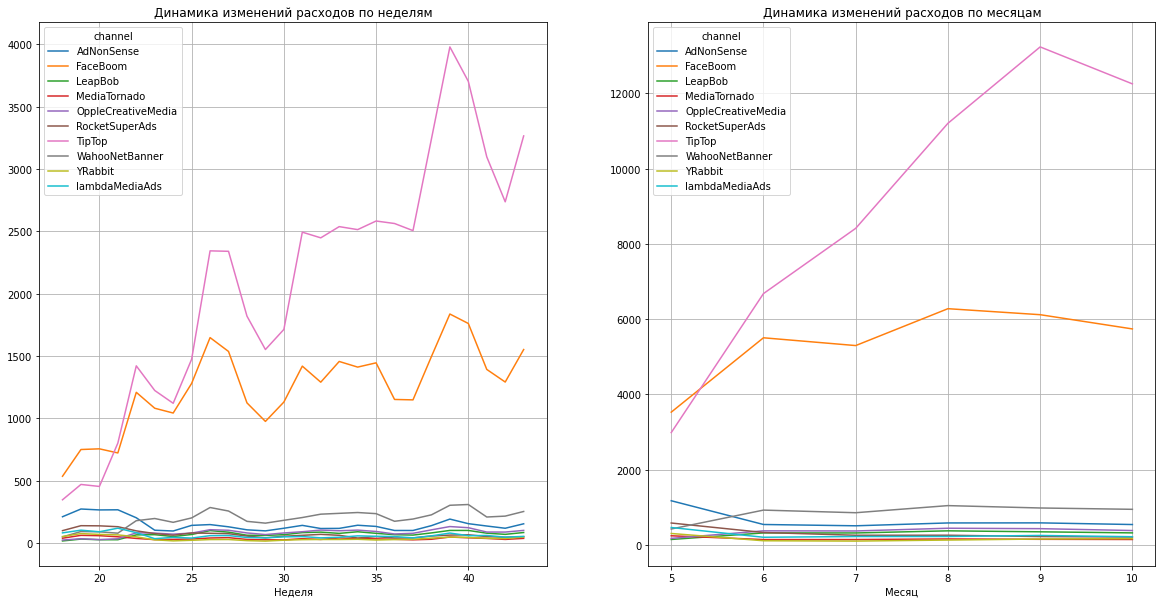

In [31]:
plt.figure(figsize=(20, 10))
ax1 = plt.subplot(1, 2, 2)
costs.pivot_table(index=months, columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax1);
plt.xlabel('Месяц');
plt.title('Динамика изменений расходов по месяцам');

ax2 = plt.subplot(1, 2, 1)
costs.pivot_table(index=weeks, columns='channel', values='costs', aggfunc='sum').plot(grid=True, ax=ax2);
plt.xlabel('Неделя');
plt.title('Динамика изменений расходов по неделям');

Видим динамику расходов. TipTop и FaceBoom заметно выделяются. Как показывают графики, с начала рекламных кампаний, основной бюджет уходил именно на эти два источника, причем со временем расходы на них только росли. Видимо, из-за растущих аудиторий данных площадок. Остальные каналы стабильно пользовались низким спросом.



Посмотрим, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника

In [32]:
profiles.query('payer == True').groupby('channel').agg({'acquisition_costs': 'mean'}).round(2)\
   .sort_values(by=('acquisition_costs'), ascending=False)

acquisition_costs
channel                              
TipTop                           2.79
FaceBoom                         1.11
AdNonSense                       1.01
lambdaMediaAds                   0.74
WahooNetBanner                   0.60
RocketSuperAds                   0.42
OppleCreativeMedia               0.25
MediaTornado                     0.22
LeapBob                          0.21
YRabbit                          0.21
organic                          0.00

Привлечение пользователей с tiptop в 2.5 раза превышает стоимость привлечения пользователей с faceboom. И обходятся популярные каналы дороже

### Оценка окупаемости рекламы

Анализ окупаемость рекламы графиками LTV, ROI и CAC. Точка старта -  1 ноября 2019 года, в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения.

- Графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Графики конверсии и удержания пользователей; динамика изменений.
- Окупаемость рекламы с разбивкой по устройствам.
- Окупаемость рекламы с разбивкой по странам. 
- Окупаемость рекламы с разбивкой по рекламным каналам.


#### Окупаемость рекламы общие показатели

Отфильтруем органик пользователей. Их привлечение бесплатное, поэтому с определением проблем в рекламном бюджете они не помогут

In [33]:
profiles_filt = profiles[profiles.channel != 'organic']

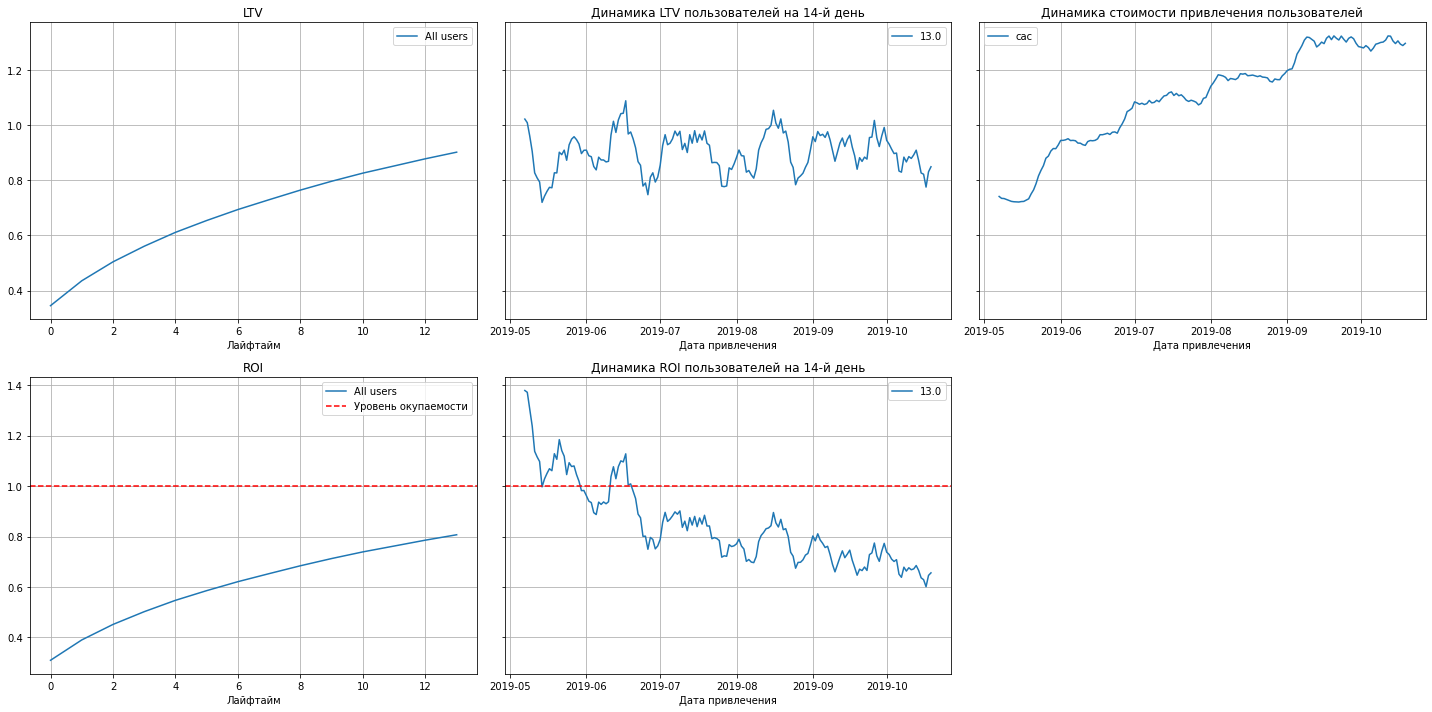

In [34]:
#построим графики Lifetime value + return on investment
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filt, orders, datetime(2019,11,1).date(), 14)
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

Наблюдаем явные проблемы. LTV показывает, что юзеры покупают. Но расходы на рекламу растут, как и расходы на привлечение пользователей, а динамика roi падает, и привлеченные пользователи даже и близко не подошли к окупаемости расходов. за две недели окупилось чуть больше 80% рекламных вложений. дело все-таки в неправильно выбранных источниках рекламных закупок или?...

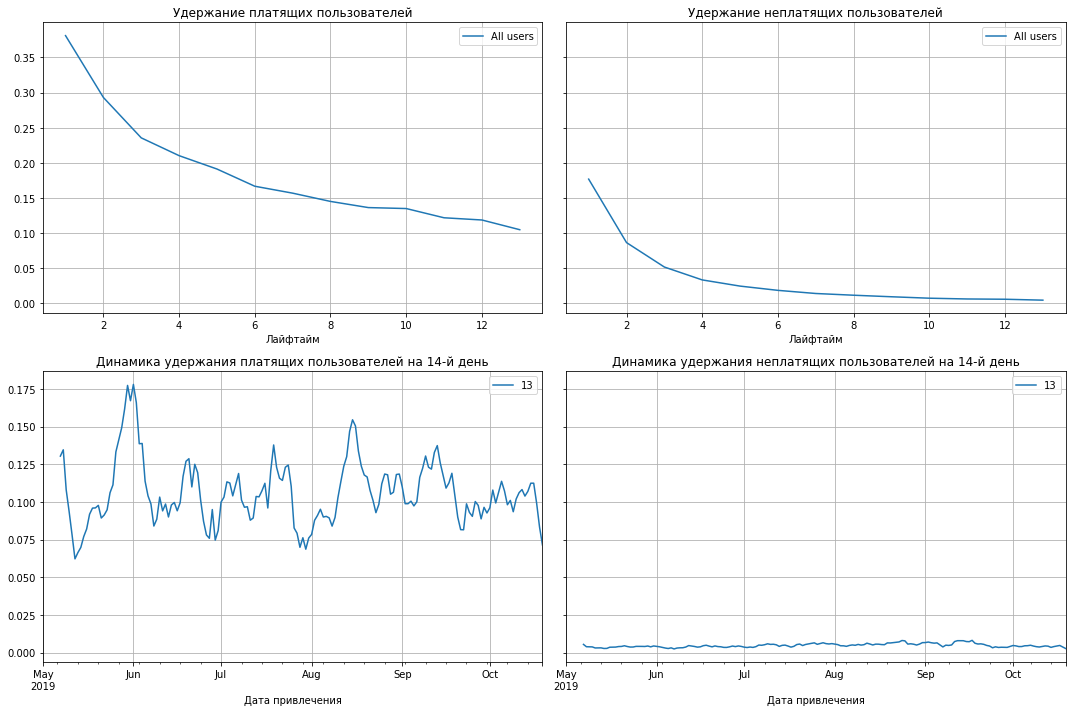

In [35]:
#графики удержания
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filt, visits, datetime(2019,11,1).date(), 14)

plot_retention(retention_grouped, retention_history, 14) 

Удержание платящих и неплатящих падает. Сезонность не влияет. Далее попробуем разобраться, в чем проблема. Посмотрим на конверсию пользователей

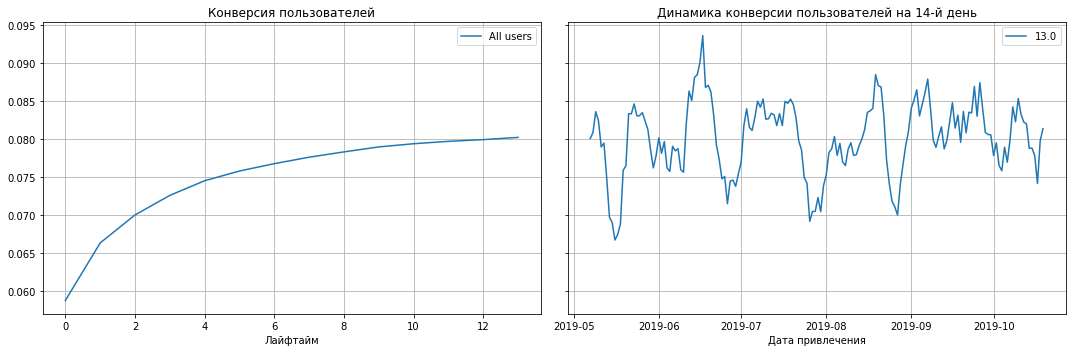

In [36]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filt, orders, datetime(2019,11,1).date(), 14)
plot_conversion(conversion_grouped, conversion_history, 14) 

пользователи конвертируются очень хорошо. Проблема в удержании? посмотрим дальше с разбивкой по категориям

#### Окупаемость рекламы [устройства]

Посмотрим на показатели с разбивкой по устройствам пользователей

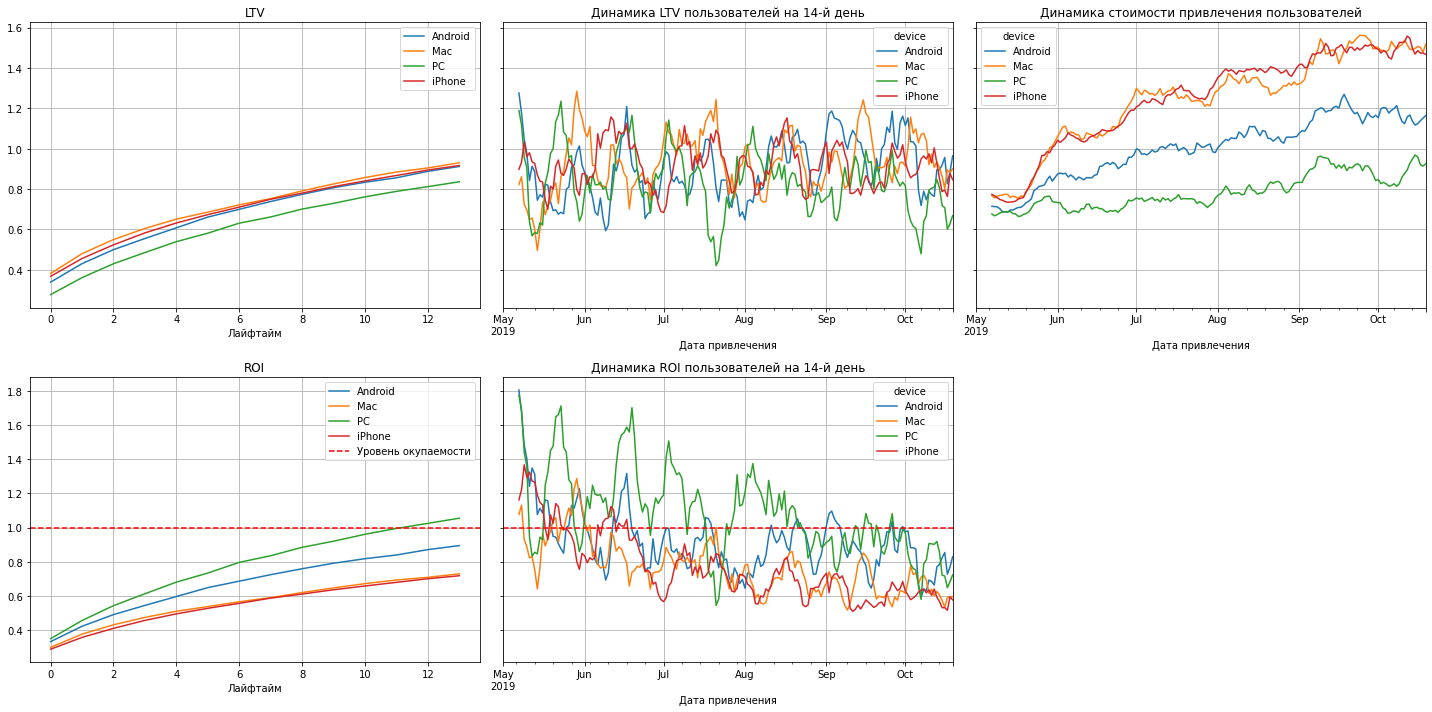

In [37]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filt, orders, datetime(2019,11,1).date(), 14, dimensions=['device'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

Стоимость привлечения юзеров на устройства от эппл растут быстрее всего и превышают расходы для других устройств в несколько раз. За 14 дней окупается только PC. Но в динамике видим, что и он с сентября перестает окупаться. Все остальные источники - провальные. 

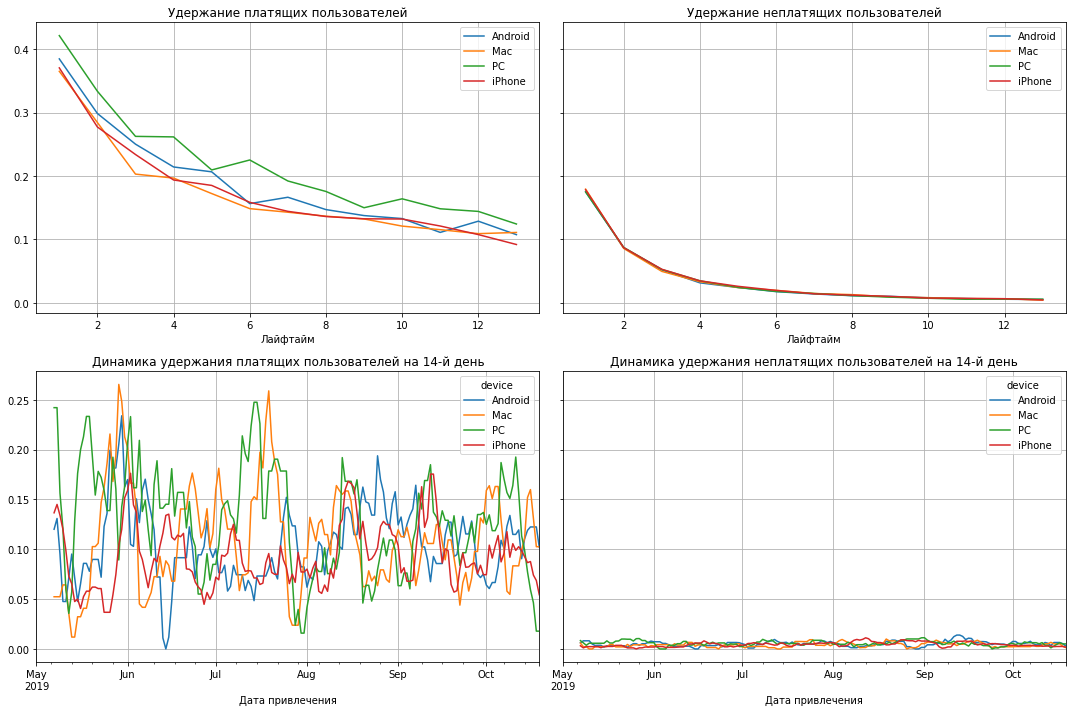

In [38]:
#посмотрим на удержание по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filt, visits, datetime(2019,11,1).date(), 14, dimensions=['device'])

plot_retention(retention_grouped, retention_history, 14) 

удержание по всем устройствам стабильно падает. слишком низкие показатели. посмотрим дальше, что еще не так

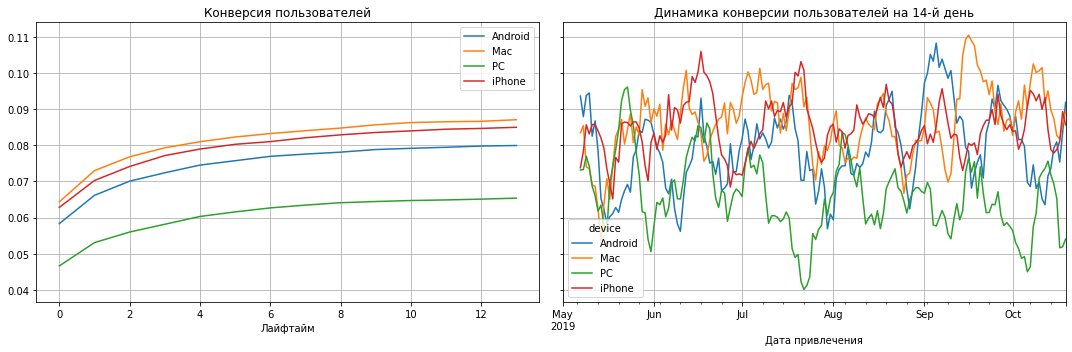

In [39]:
#графики конверсии
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filt, orders, datetime(2019,11,1).date(), 14, dimensions=['device'])
plot_conversion(conversion_grouped, conversion_history, 14) 

конверсия пользователей со всех устройств растет со временем. пользователи пк отстают от всех остальных, но проблема не в этом, а в падающем удержании

#### Окупаемость рекламы [страны]

Посмотрим на показатели с разбивкой по странам

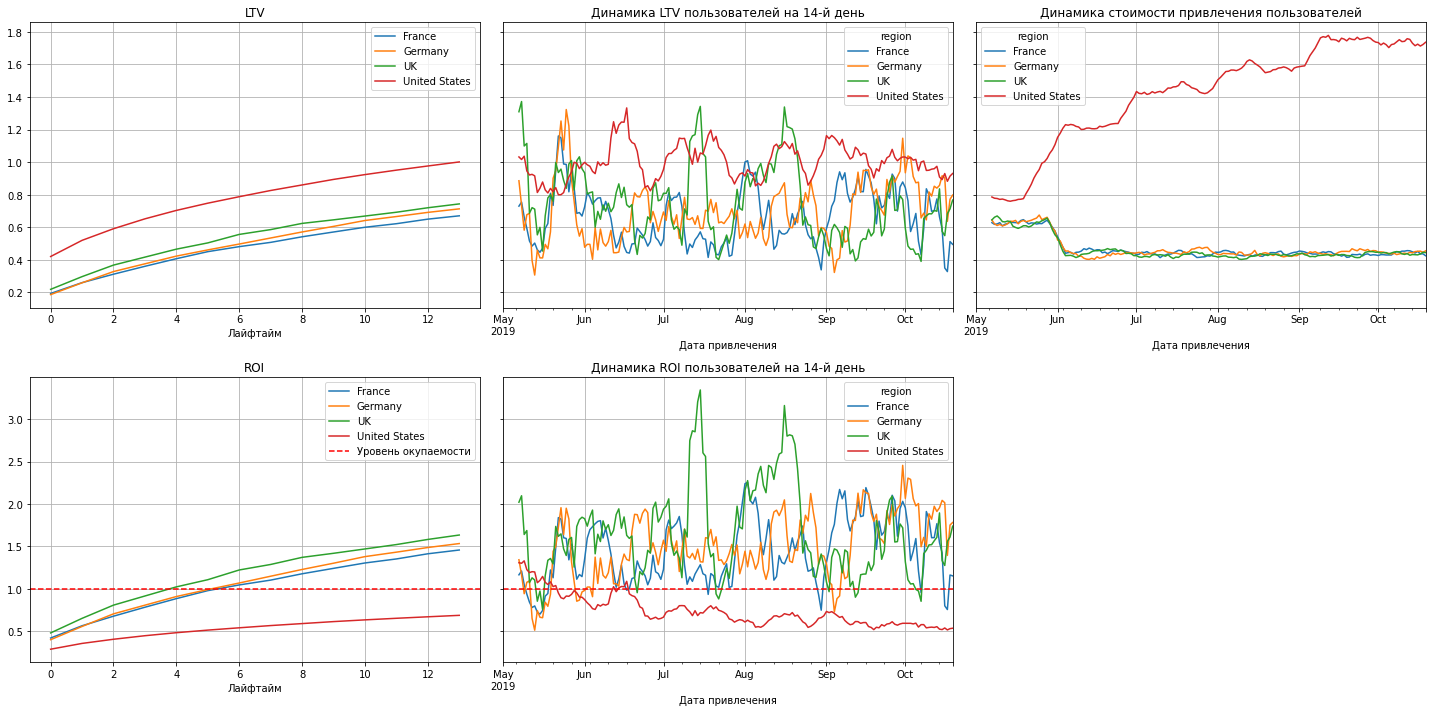

In [40]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filt, orders, datetime(2019,11,1).date(), 14, dimensions=['region'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

Слишком много бюджета утекает в сша. Стоимость американской рекламы просто невероятно высокая по сравнению с европейской, а окупаемость около 70%. Вся нацеленная на Европу реклама окупилась. 

Изучим поподробнее рекламу в США. Посмотрим, какие конкретно из каналов привлечения не окупаются

In [41]:
#фильтруем таблицу юзеров из сша
profiles_usa = profiles[profiles.region == 'United States']

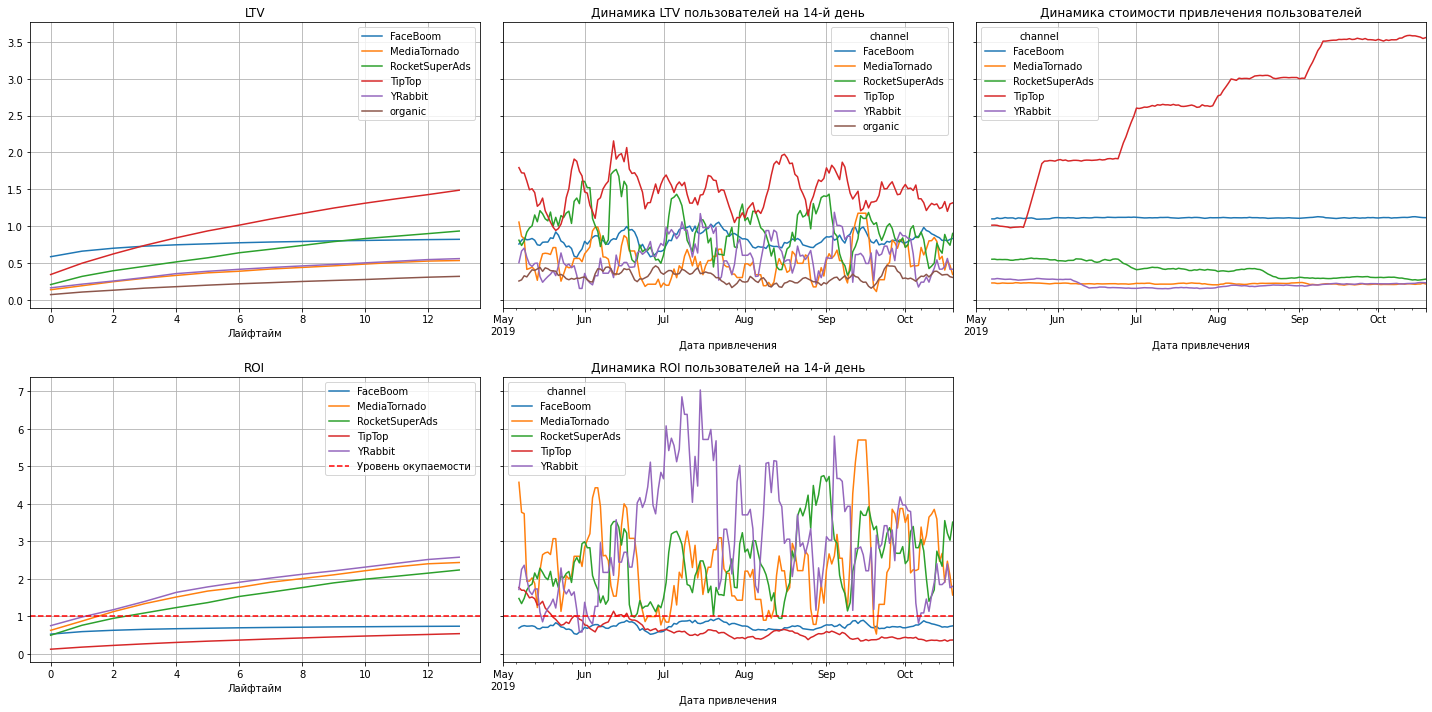

In [42]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

окупаются все, кроме tiptop + faceboom. что было очевидно из предыдущих графиков. но тут мы еще выделили rocketsuperads и mediatornda -  каналы, у который все в порядке с ltv, roi, динамиками, и цены на привлечение пользователей стабильно низкие

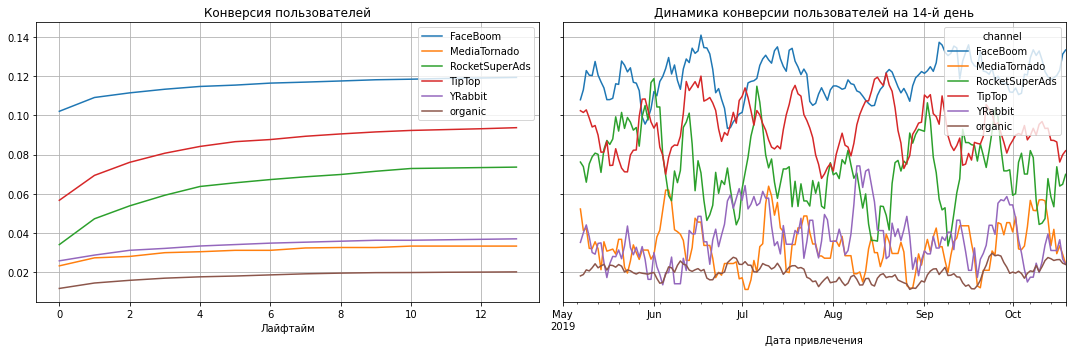

In [43]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, 14) 

Посмотрим, какие каналы привлечений самые лучшие для европейских стран

In [44]:
# франция
profiles_france = profiles[profiles.region == 'France']

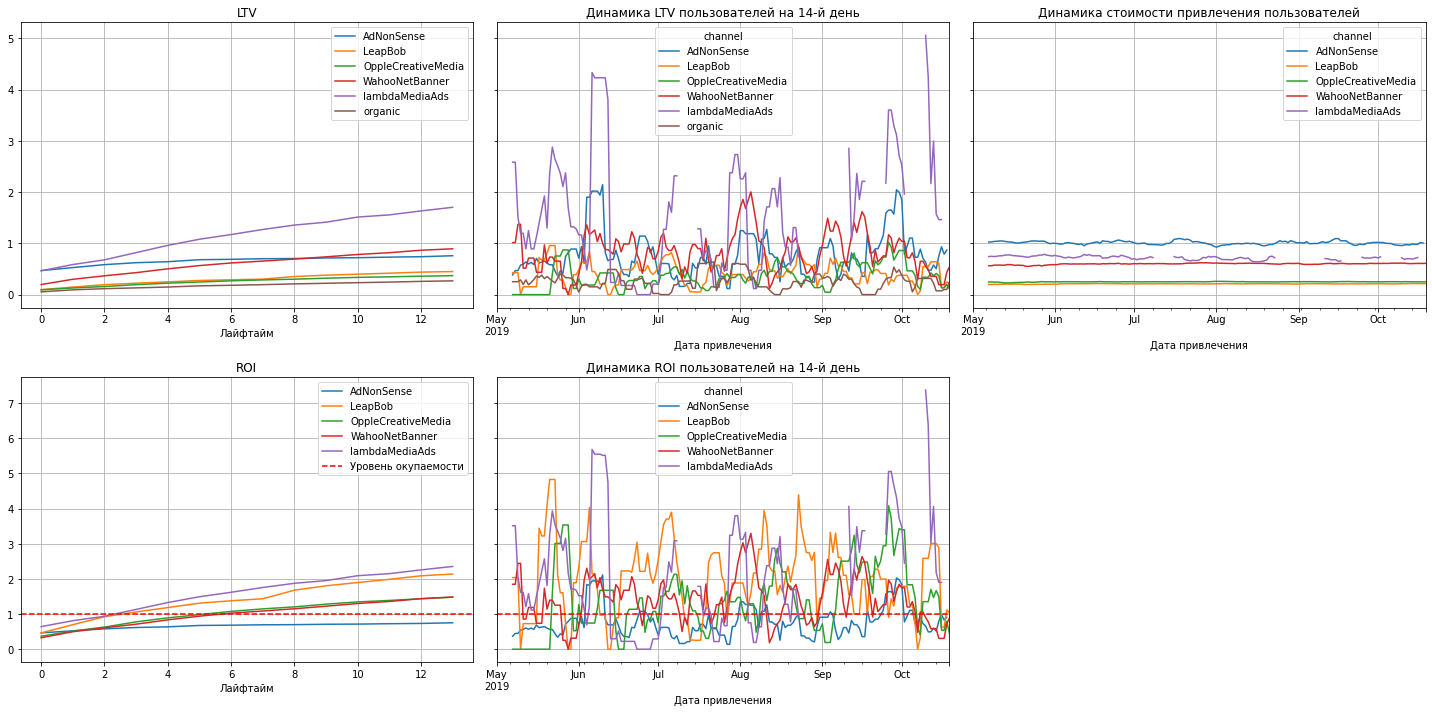

In [45]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_france, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

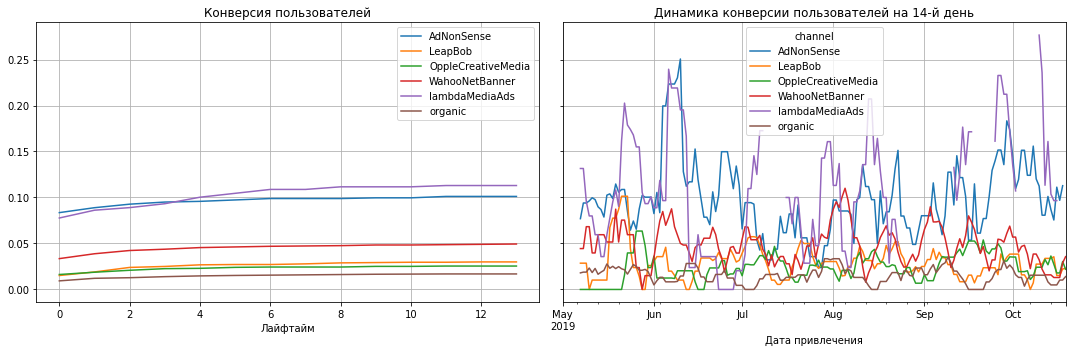

In [46]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_france, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, 14) 

стабильно окупающийся канал во франции - lambdamediaads

In [47]:
#смотрим uk
profiles_uk = profiles[profiles.region == 'UK']

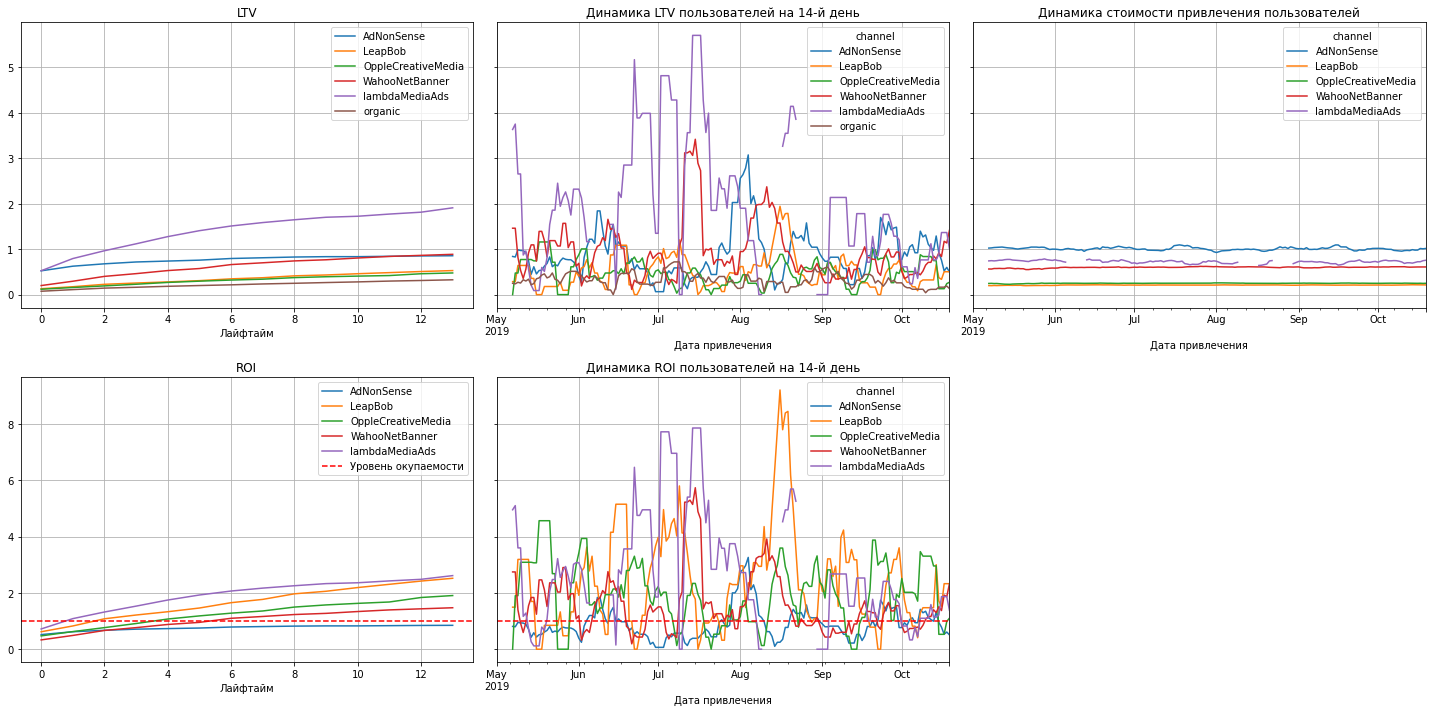

In [48]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_uk, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

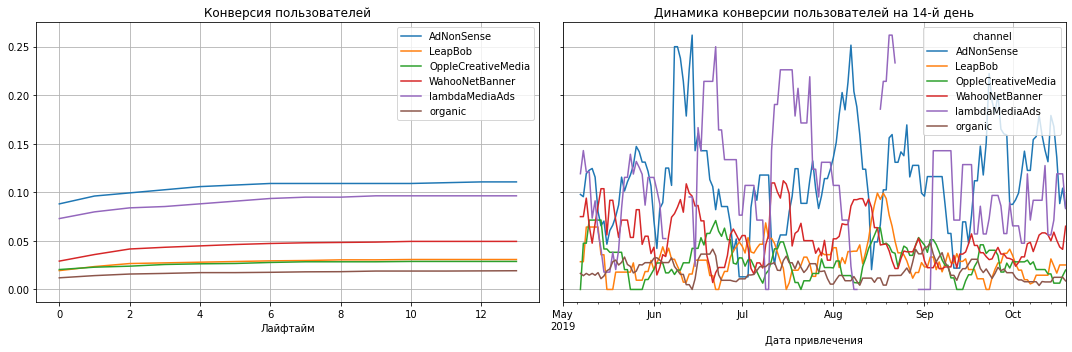

In [49]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_uk, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, 14) 

In [50]:
#смотрим германию
profiles_germany = profiles[profiles.region == 'Germany']

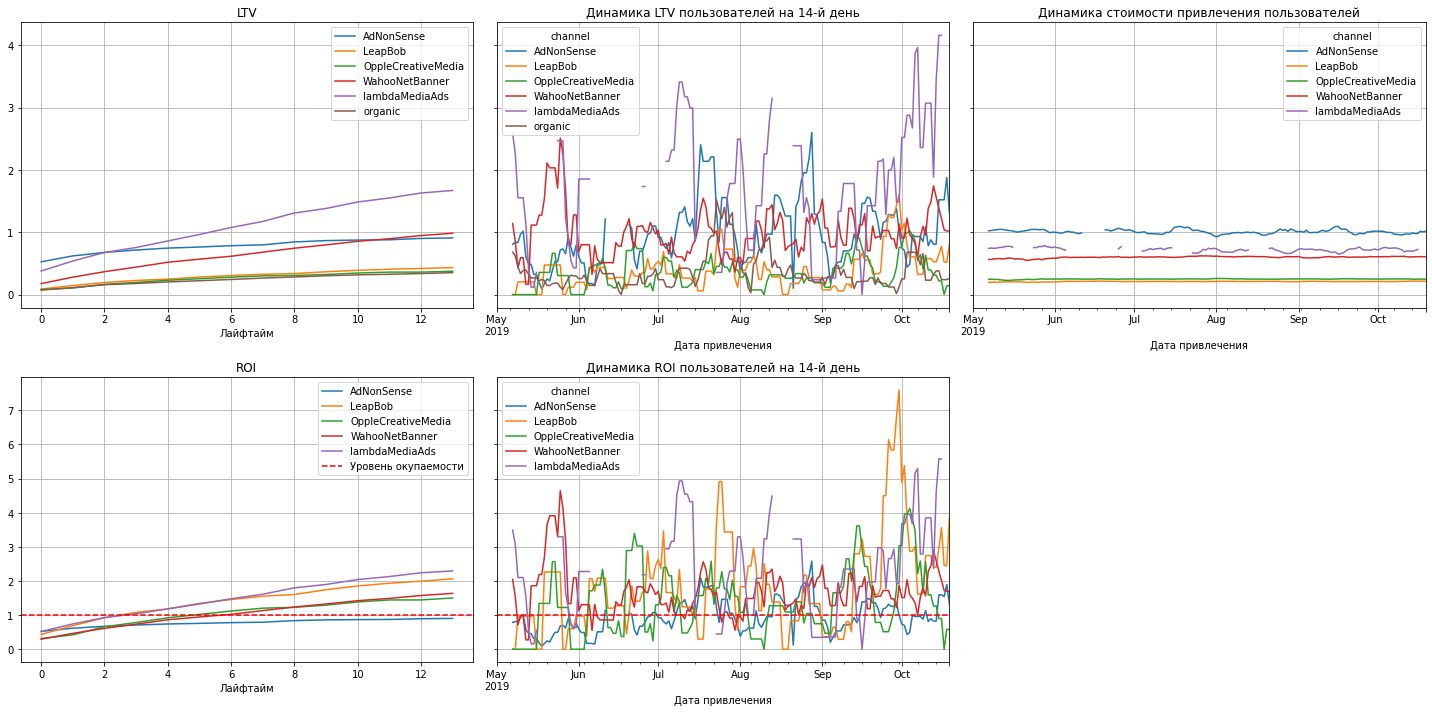

In [51]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_germany, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

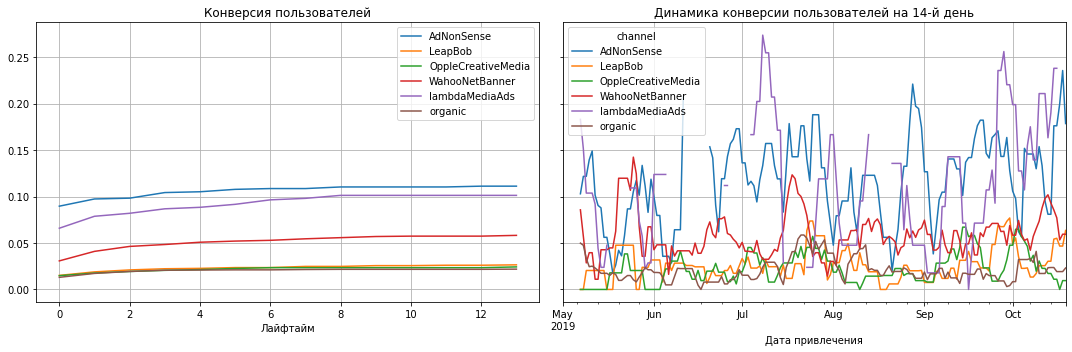

In [52]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_germany, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, 14) 

в европе очевидный выбор - lambdamediaads + wahoonetbanner, со стабильно растущими ltv + roi и низкой стоимостью привлечения. конверсия у adnonsense высокая, НО реклама не окупается

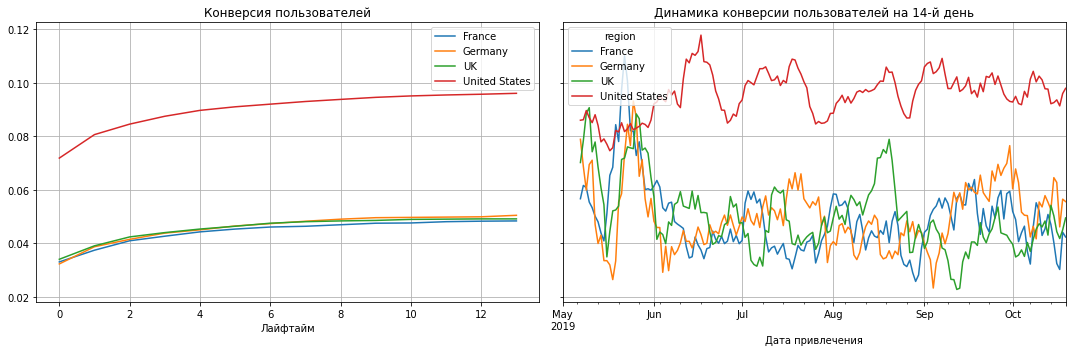

In [53]:
#посмотрим на общую конверсию по странам
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filt, orders, datetime(2019,11,1).date(), 14, dimensions=['region'])
plot_conversion(conversion_grouped, conversion_history, 14) 

интересно получается, в США конверсия заметно выше, посмотрим на удержание

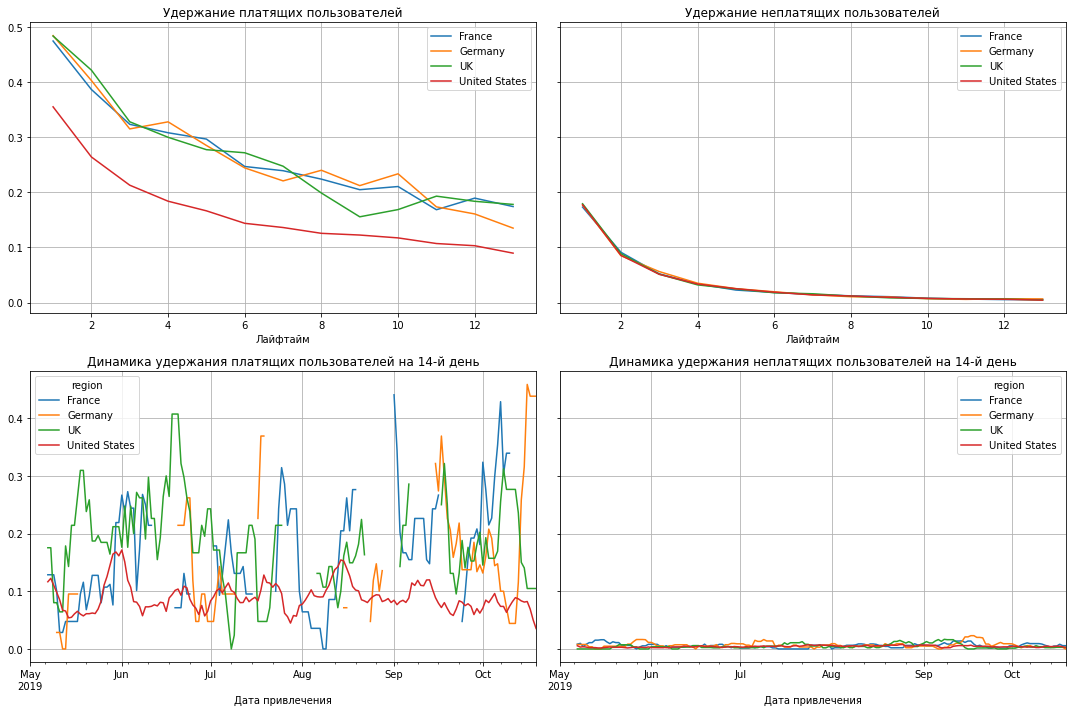

In [54]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filt, visits, datetime(2019,11,1).date(), 14, dimensions=['region'])

plot_retention(retention_grouped, retention_history, 14) 

Похожая картина с удержанием, которое стабильно падает. Еще одну проблему в США обнаружили. Удержание платящих пользователей значительно ниже стран европы. 

Разрывы на графиках объясняются тем, что по европе и части каналов очень мало пользователей (видели при расчете доли платящих), видимо, в какой-то момент за 2 недели не было не одного покупателя, когорта получилась пустая.


#### Окупаемость рекламы [каналы]

Посмотрим на показатели с разбивкой по каналам привлечения

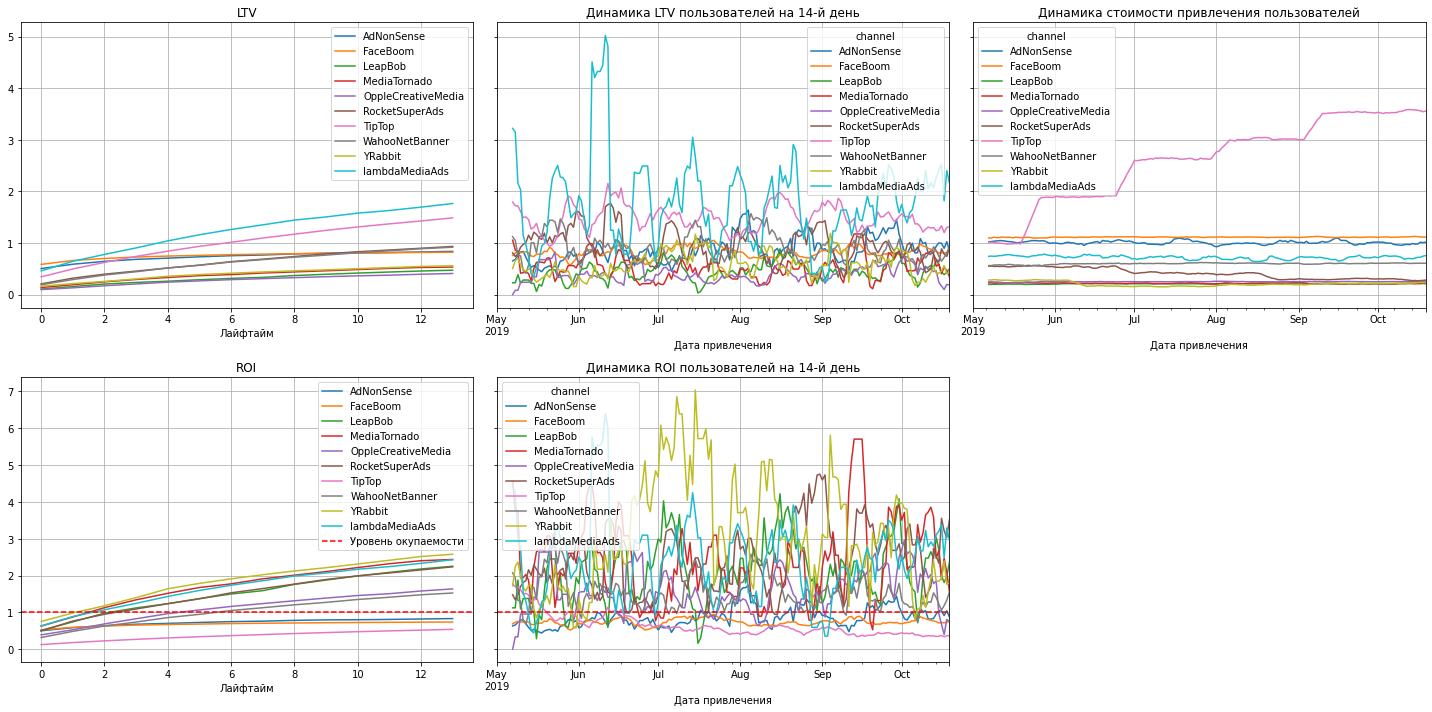

In [55]:
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_filt, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, 14) 

Очень много каналов. Можно запутаться, но нас уже интересуют только два канала (Tiptop + Faceboom) - проблемные каналы. Стоиомсть привлечения пользователей с этих двух в несколько раз превышает расходы на пользователей с других каналов. Но несмотря на высокие вложения, реклама с них не окупается. По другим каналам все более радужно. Больше всего окупились YRabbit, MediaTornado, lambdaMediaAds. Странно то, что реклама в AdNonSense не окупилась, хотя стоимость привлечения пользователей стабильна, и этот канал находится на 2м месте по % платящих пользователей (11.34% и 3880 общее число юзеров)

Посмотрим на конверсию и удержание пользователей по каналам привлечения

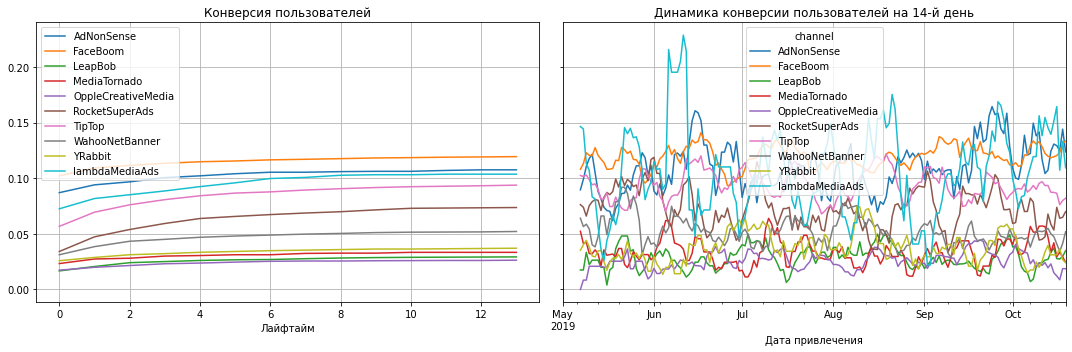

In [56]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_filt, orders, datetime(2019,11,1).date(), 14, dimensions=['channel'])
plot_conversion(conversion_grouped, conversion_history, 14)

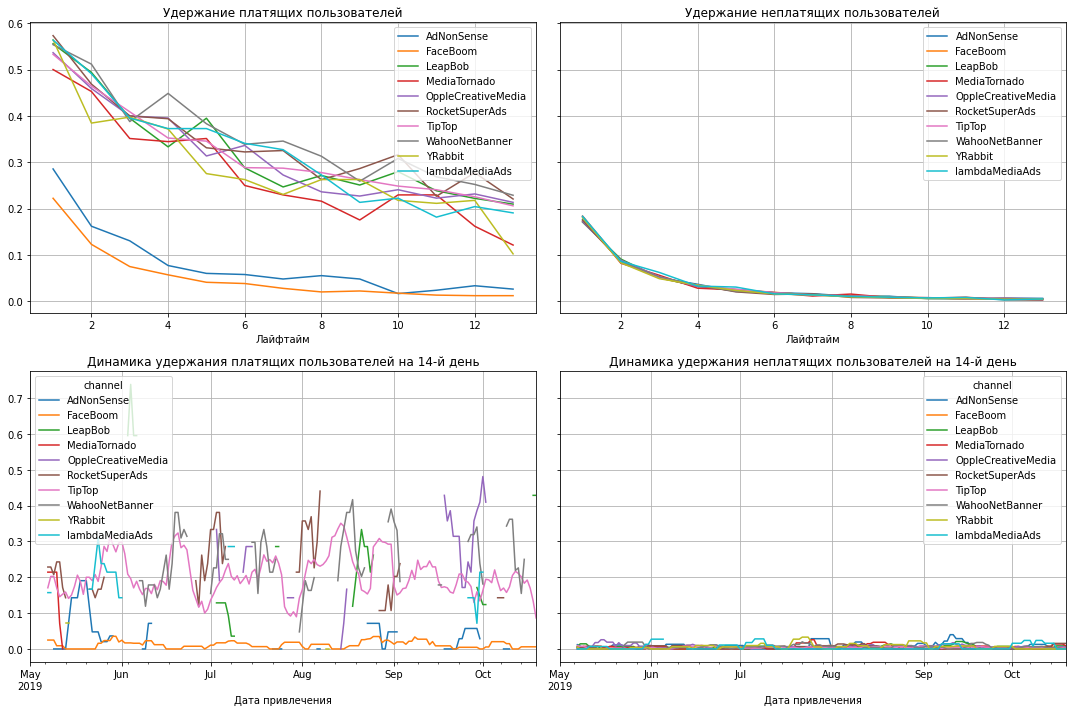

In [57]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_filt, visits, datetime(2019,11,1).date(), 14, dimensions=['channel'])

plot_retention(retention_grouped, retention_history, 14) 

+- положительная конверсия у adnonsense, faceboom, tiptop, lambdamediaads,  rocketsuperads.  Но удержание оставляет желать лучшего, особенно у пользователей с faceboom + adnonsense (показатели падают практически до нуля). Удержание падает практически всегда, никто вечно не сидит в приложениях, но можно попробовать вводить новые фичи и интерактивы в приложение более регулярно, чтобы у пользователей был стимул продолжать им пользоваться

### Выводы


* Перед проведением анализа, данные из 3х ДФ были отформатированы (названия колонок -> lowercase), колонки со временем были приведены к типу datetime для удобства использований функций для подсчета важных для анализа параметров
* Создана пользовательская таблица с данными. Всего 150008 пользователей в системе. Максимальная дата привлечения юзера = 27.10.2019. Минимальная = 01.05.2019

* Платящие пользователи из 4х стран: США (6.9% платящих юзеров), Германия (4.1%), Великобритания (3.98%), Франция (3.8%)
  В США количество платящих пользователей больше, чем в европе, и это количество мжно увеличить в несколько раз, если изменить приоритетные каналы привлечения (подробнее ниже)
  
* Наибольшее кол-во платящих юзеров используют технику apple (Mac пользователи = 6.36%, iphone = 6.21). Андроид и ПК юзеры отстают, но разница назначительная (5.85% и 5.05% соответственно)

* Как выяснилось, вместо одной проблемы, у нас их две - плохое распределение рекламного бюджета И стабильно низкое удержание пользователей по всем параметрам (каналы, регионы, устройства). в имеющихся датасетах недостаточно информации для выявления потенциальных причин по удежранию. Возможно, проблема в тех ошибках, либо же в отсутствии апдейтов и добавления новых фич в приложение.

* Что касается рекламного бюджета в США, каналы, на которые сейчас тратится 83% рекламного бюджета (tiptop + faceboom) не окупаются + имеют слишком высокую стоимость привлечения пользователей (средние значения CAC = 29.15 и 9.12 соответственно). конверсия у этих двух каналов высокая, но удержание пользователей c faceboom сводится практически к 0 к концу второй недели. Соответственно, бесполезно вливать столько бюджета в эти два канала, имея никакой выгоды. вместо этого выделили rocketsuperads и mediatorndao, каналы, у которых все в порядке с ltv, roi, динамиками, и конверсией,  и цены на привлечение пользователей стабильно низкие.

* По европе - очевидный выбор = lambdamediaads + wahoonetbanner, с хорошей конверсией, со стабильно растущими ltv + roi и низкой стоимостью привлечения. конвертация у adnonsense высокая, НО реклама не окупается